In [93]:
import torch
from torchvision import transforms
import torchstain
import cv2
import time
import matplotlib.pyplot as plt
import os, glob
import numpy as np

### 1. Color Normalization

In [94]:
#reference image
target = cv2.cvtColor(cv2.imread("/Users/salma/Desktop/Leuk/data/train/ALL/Image_4184.png"), cv2.COLOR_BGR2RGB)

In [129]:
DIR = '/Users/salma/Desktop/Leuk/data/train/CML'
OUT = '/Users/salma/Desktop/Leuk/data/CML_train_processed'

#if OUT directory does not exist, create it
if not os.path.exists(OUT):
    os.makedirs(OUT)

In [10]:
import cv2
import numpy as np
from PIL import Image
import os

# Load the histopathology image and its mask
image_path = '/Users/salma/Desktop/Leuk/data/train_color_normalized_resized/ALL/44-22-252-2243 - 9.png'
mask_path = '/Users/salma/Desktop/Leuk/data/generated_train_masks/ALL/44-22-252-2243 - 9_mask.png'
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Find contours in the mask
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# The padding you want to add to the crops
padding = 10

# Directory where you want to save the crops
save_dir = './cropped_cells/'

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Loop through the contours and save each crop
for i, contour in enumerate(contours):
    # Compute the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Add padding to the bounding box
    x_pad = max(x - padding, 0)
    y_pad = max(y - padding, 0)
    w_pad = min(w + 2 * padding, image.shape[1] - x_pad)
    h_pad = min(h + 2 * padding, image.shape[0] - y_pad)

    # Crop the image around the bounding box
    crop = image[y_pad:y_pad + h_pad, x_pad:x_pad + w_pad]

    # Convert the crop to a PIL Image and save
    crop_img = Image.fromarray(crop)
    crop_img.save(os.path.join(save_dir, f"cell_{i}.png"))


In [130]:
#loop through all images in the directory
for filename in os.listdir(DIR):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
        to_transform = cv2.cvtColor(cv2.imread(os.path.join(DIR, filename)), cv2.COLOR_BGR2RGB)
        T = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: x*255)
        ])

        normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        normalizer.fit(T(target))

        t_to_transform = T(to_transform)
        norm, H, E = normalizer.normalize(I=t_to_transform, stains=True)
        #save H image
        H = np.array(H)
        E = np.array(E)
        norm = np.array(norm)
        file_noext = os.path.splitext(filename)[0]
        cv2.imwrite(os.path.join(OUT, file_noext) + ".png", norm)

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path

def crop_and_save_cells(image_path, mask_path, output_dir, padding=10):
    # Load the image and the mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, 0)  # Load mask as grayscale
    if image is None or mask is None:
        print(f"Error loading image or mask for {image_path}")
        return

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create the output subfolder if it doesn't exist
    subfolder_path = Path(output_dir) / Path(image_path).parent.name
    subfolder_path.mkdir(parents=True, exist_ok=True)

    # Iterate through contours and crop the image around each contour
    for i, contour in enumerate(contours):
        # Compute the bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add padding
        x1 = max(x - padding, 0)
        y1 = max(y - padding, 0)
        x2 = min(x + w + padding, image.shape[1])
        y2 = min(y + h + padding, image.shape[0])
        
        # Crop the image
        cropped_image = image[y1:y2, x1:x2]

        # Save the cropped image
        cropped_filename = f"{Path(image_path).stem}_cropped_{i}{Path(image_path).suffix}"
        cropped_image_path = str(subfolder_path / cropped_filename)
        cv2.imwrite(cropped_image_path, cropped_image)

def process_directory(image_dir, mask_dir, output_dir):
    # Walk through the image directory
    for subdir, dirs, files in os.walk(image_dir):
        for filename in files:
            if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                continue  # Skip non-image files

            # Construct full file paths
            image_path = os.path.join(subdir, filename)
            mask_name = f"{os.path.splitext(filename)[0]}_mask.png"
            mask_path = os.path.join(mask_dir, Path(subdir).name, mask_name)

            # Perform the crop and save operation
            crop_and_save_cells(image_path, mask_path, output_dir)

# Example usage:
image_directory = '/Users/salma/Desktop/Leuk/data/val_color_normalized_resized/'  # Replace with your image directory
mask_directory = '/Users/salma/Desktop/Leuk/data/val_norm_mask_resized/'    # Replace with your mask directory
output_directory = 'val_Cell_Cropped' # Replace with your output directory
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
process_directory(image_directory, mask_directory, output_directory)

In [114]:
import os
import shutil

# Path to the directory containing the images
images_folder = '/Users/salma/Desktop/Leuk/data/val_norm/CML'

# Create subfolders '1', '2', and '3' inside the images folder
for i in range(1, 4):
    os.makedirs(os.path.join(images_folder, str(i)), exist_ok=True)

# Get a list of images in the images folder
images = [img for img in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, img))]

# Distribute the images into the subfolders
for index, image in enumerate(images):
    destination_folder = os.path.join(images_folder, str((index % 3) + 1))
    source_path = os.path.join(images_folder, image)
    destination_path = os.path.join(destination_folder, image)
    shutil.move(source_path, destination_path)

print("Images have been distributed into subfolders '1', '2', and '3'.")

Images have been distributed into subfolders '1', '2', and '3'.


In [91]:
to_transform= cv2.cvtColor(cv2.imread("/Users/salma/Desktop/Leuk/data/train_resized/442022319551_2_resized.jpeg"), cv2.COLOR_BGR2RGB)
target = cv2.cvtColor(cv2.imread("/Users/salma/Desktop/Leuk/data/train_resized/44-22-252-2243 - 1_resized.jpeg"), cv2.COLOR_BGR2RGB)
# to_transform = cv2.cvtColor(cv2.imread("./data/train/ALL/44220091255A_7.jpg"), cv2.COLOR_BGR2RGB)

T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])

normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
normalizer.fit(T(target))

t_to_transform = T(to_transform)
norm, H, E = normalizer.normalize(I=t_to_transform, stains=True)

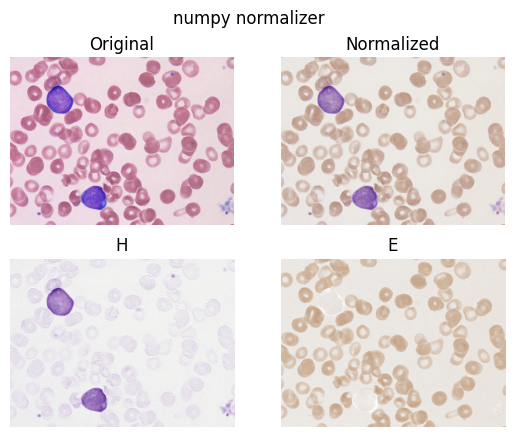

In [92]:
plt.figure()
plt.suptitle('numpy normalizer')
plt.subplot(2, 2, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(to_transform)

plt.subplot(2, 2, 2)
plt.title('Normalized')
plt.axis('off')
plt.imshow(norm)

plt.subplot(2, 2, 3)
plt.title('H')
plt.axis('off')
plt.imshow(H)

plt.subplot(2, 2, 4)
plt.title('E')
plt.axis('off')
plt.imshow(E)
plt.show()

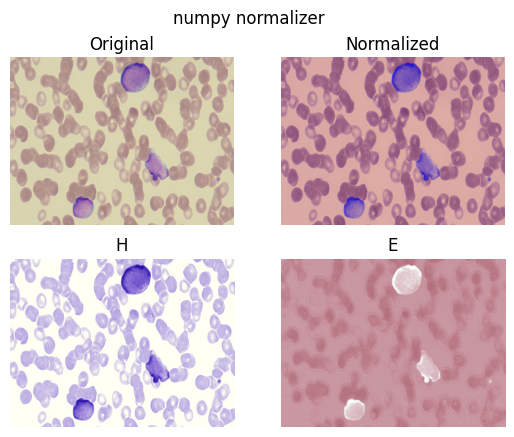

In [90]:
plt.figure()
plt.suptitle('numpy normalizer')
plt.subplot(2, 2, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(to_transform)

plt.subplot(2, 2, 2)
plt.title('Normalized')
plt.axis('off')
plt.imshow(norm)

plt.subplot(2, 2, 3)
plt.title('H')
plt.axis('off')
plt.imshow(H)

plt.subplot(2, 2, 4)
plt.title('E')
plt.axis('off')
plt.imshow(E)
plt.show()

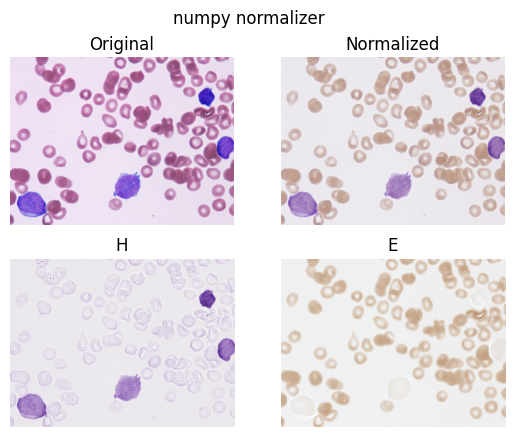

In [16]:
plt.figure()
plt.suptitle('numpy normalizer')
plt.subplot(2, 2, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(to_transform)

plt.subplot(2, 2, 2)
plt.title('Normalized')
plt.axis('off')
plt.imshow(norm)

plt.subplot(2, 2, 3)
plt.title('H')
plt.axis('off')
plt.imshow(H)

plt.subplot(2, 2, 4)
plt.title('E')
plt.axis('off')
plt.imshow(E)
plt.show()

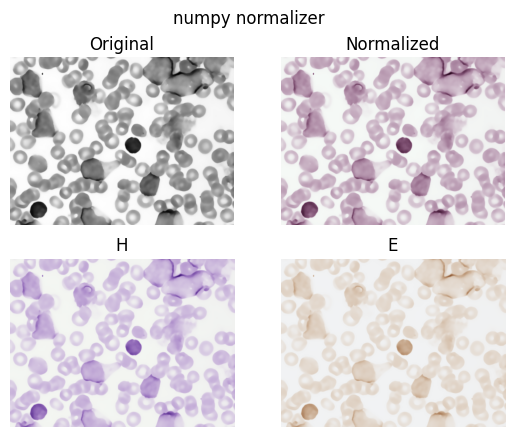

In [23]:
plt.figure()
plt.suptitle('numpy normalizer')
plt.subplot(2, 2, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(to_transform)

plt.subplot(2, 2, 2)
plt.title('Normalized')
plt.axis('off')
plt.imshow(norm)

plt.subplot(2, 2, 3)
plt.title('H')
plt.axis('off')
plt.imshow(H)

plt.subplot(2, 2, 4)
plt.title('E')
plt.axis('off')
plt.imshow(E)
plt.show()

In [ ]:
from transformers import AutoModelForImageSegmentation, AutoFeatureExtractor
from PIL import Image
import torch
import requests
from io import BytesIO

# Load the feature extractor and model from Hugging Face
feature_extractor = AutoFeatureExtractor.from_pretrained("Lewislou/cellseg_sribd")
model = AutoModelForImageSegmentation.from_pretrained("Lewislou/cellseg_sribd")

# Load image
image_path = '/mnt/data/44221290379A_23.png'
image = Image.open(image_path)

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Make the image a batch of one
inputs = {k: v.unsqueeze(0) for k, v in inputs.items()}

# Run the model
outputs = model(**inputs)
logits = outputs.logits  # you get logits as a result

# Postprocess logits to get the segmentation masks
# This would typically involve thresholding the logits to get a binary mask
masks = logits.argmax(dim=1)

# Convert PyTorch tensor to numpy array
masks_np = masks.detach().cpu().numpy()

# Visualize the mask
import matplotlib.pyplot as plt

plt.imshow(masks_np[0], cmap='gray')
plt.axis('off')
plt.show()


In [85]:


from skimage import io, segmentation, morphology, measure, exposure
from sribd_cellseg_models import MultiStreamCellSegModel,ModelConfig
import numpy as np
import tifffile as tif
import requests
import torch
from PIL import Image
from overlay import visualize_instances_map
import cv2
img_name = 'test_images/cell_00551.tiff'

def normalize_channel(img, lower=1, upper=99):
    non_zero_vals = img[np.nonzero(img)]
    percentiles = np.percentile(non_zero_vals, [lower, upper])
    if percentiles[1] - percentiles[0] > 0.001:
        img_norm = exposure.rescale_intensity(img, in_range=(percentiles[0], percentiles[1]), out_range='uint8')
    else:
        img_norm = img
    return img_norm.astype(np.uint8)
if img_name.endswith('.tif') or img_name.endswith('.tiff'):
    img_data = tif.imread(img_name)
else:
    img_data = io.imread(img_name)
        # normalize image data
if len(img_data.shape) == 2:
    img_data = np.repeat(np.expand_dims(img_data, axis=-1), 3, axis=-1)
elif len(img_data.shape) == 3 and img_data.shape[-1] > 3:
    img_data = img_data[:,:, :3]
else:
    pass
pre_img_data = np.zeros(img_data.shape, dtype=np.uint8)
for i in range(3):
    img_channel_i = img_data[:,:,i]
    if len(img_channel_i[np.nonzero(img_channel_i)])>0:
        pre_img_data[:,:,i] = normalize_channel(img_channel_i, lower=1, upper=99)
#dummy_input = np.zeros((512,512,3)).astype(np.uint8)
my_model = MultiStreamCellSegModel.from_pretrained("Lewislou/cellseg_sribd")
checkpoints = torch.load('model.pt')
my_model.__init__(ModelConfig())
my_model.load_checkpoints(checkpoints)
with torch.no_grad():
    output = my_model(pre_img_data)
overlay = visualize_instances_map(pre_img_data,star_label)
cv2.imwrite('prediction.png', cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))


ModuleNotFoundError: No module named 'sribd_cellseg_models'

In [119]:
import cv2
import numpy as np
import os
from pathlib import Path
from PIL import Image, ImageFilter

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Fill holes using morphological closing operation
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size if necessary
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    #smoothen the edges
    closed_image = cv2.GaussianBlur(closed_image, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)

    # Save the processed image
    cv2.imwrite(output_path, closed_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [120]:
import cv2
import numpy as np
import os

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def findBiggestContour(contours):
    max_area = 0
    index = -1
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            index = i
    return index

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create a binary image where white represents the skin tone range
    skin_mask = cv2.inRange(hsv_image, (0, 48, 80), (20, 255, 255))

    # Find contours
    contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the biggest contour
    s = findBiggestContour(contours)

    # Draw the biggest contour
    output = np.zeros_like(skin_mask)
    cv2.drawContours(output, contours, s, 255, -1, 8, hierarchy, 0)

    # Save the processed image
    cv2.imwrite(output_path, output)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [121]:
import cv2
import numpy as np
import os

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Detect edges
    edges = cv2.Canny(binary_image, 100, 200)

    # Dilate and erode the edges to smooth them
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)
    smoothed_edges = cv2.erode(dilated_edges, kernel, iterations=1)

    # Combine the smoothed edges with the original binary image
    smoothed_image = cv2.bitwise_or(binary_image, smoothed_edges)

    # Save the processed image
    cv2.imwrite(output_path, smoothed_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [124]:
import cv2
import numpy as np
import os
from pathlib import Path
from PIL import Image, ImageFilter

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Fill holes using morphological closing operation
    kernel = np.ones((5, 5), np.uint8)  # Adjust kernel size if necessary
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    #smoothen the edges
    closed_image = cv2.GaussianBlur(closed_image, (0,0), sigmaX=3, sigmaY=3, borderType = cv2.BORDER_DEFAULT)

    edges = cv2.Canny(closed_image, 100, 200)

    # Step 2: Dilate the edges to make them thicker
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Step 3: Apply Gaussian blur to the dilated edges to smoothen them
    smoothed_edges = cv2.GaussianBlur(dilated_edges, (5, 5), 0)

    # Step 4: Add the smoothed edges back to the original image to maintain the edge locations
    smoothed_image = cv2.bitwise_or(closed_image, smoothed_edges)

    # Step 5: Threshold the image again to ensure it is binary
    _, smoothed_binary_image = cv2.threshold(smoothed_image, 1, 255, cv2.THRESH_BINARY)

    # Save the processed image
    cv2.imwrite(output_path, smoothed_binary_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.


In [126]:
import os

# Define the root directory where the subfolders are located.
root_directory = '/Users/salma/Desktop/Leuk/data/val_norm_seg'

# Walk through the directory structure.
for subdir, dirs, files in os.walk(root_directory):
    for file in files:
        # Check if the current file matches the pattern with '.png' in the middle.
        if file.endswith(".png_mask.png"):
            # Define the old and new file paths.
            old_file_path = os.path.join(subdir, file)
            new_file_path = old_file_path.replace(".png_mask.png", "_mask.png")

            # Rename the file.
            os.rename(old_file_path, new_file_path)
            print(f"Renamed '{old_file_path}' to '{new_file_path}'")


In [122]:
import cv2
import numpy as np
import os
from pathlib import Path

# Paths
source_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask'
destination_folder = '/Users/salma/Desktop/Leuk/data/val_norm_mask_processed'

def process_image(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold the image: all non-black pixels will be set to white (255)
    _, binary_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

    # Detect edges
    edges = cv2.Canny(binary_image, 100, 200)

    # Dilate the edges to make them more prominent
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Apply Gaussian blur to smooth the edges
    smoothed_edges = cv2.GaussianBlur(dilated_edges, (5, 5), 0)

    # Combine the smoothed edges with the binary image
    result_image = cv2.bitwise_or(binary_image, smoothed_edges)

    # Fill holes using morphological closing operation
    closed_image = cv2.morphologyEx(result_image, cv2.MORPH_CLOSE, kernel)

    # Save the processed image
    cv2.imwrite(output_path, closed_image)

# Traverse the source directory and process each image
for subdir, dirs, files in os.walk(source_folder):
    for file in files:
        filepath = os.path.join(subdir, file)
        if filepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            # Construct the output path
            relative_path = os.path.relpath(subdir, source_folder)
            output_dir = os.path.join(destination_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, file)
            
            # Process the image
            process_image(filepath, output_path)

print("Image processing completed.")


Image processing completed.
